In [1]:
!pip install -U transformers datasets accelerate
!pip install --upgrade transformers==4.57.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

# -----------------------------
# 1. Load and preprocess dataset
# -----------------------------
df = pd.read_csv("issues.csv")
df['label'] = df['labels'].apply(lambda x: eval(x)[0]['name'] if len(eval(x))>0 else 'unknown')

df = df.dropna(subset=['body'])
df = df[df['body'].str.strip() != ""]

df_filtered = df[df['label'] != 'unknown']

min_samples = 10
counts = df_filtered['label'].value_counts()
keep_labels = counts[counts >= min_samples].index.tolist()
df_filtered = df_filtered[df_filtered['label'].isin(keep_labels)]

df_filtered['body'] = df_filtered['body'].astype(str)

# -----------------------------
# 2. Split into train/test
# -----------------------------
train_df, test_df = train_test_split(
    df_filtered,
    test_size=0.2,
    stratify=df_filtered['label'],
    random_state=42
)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# -----------------------------
# 3. Load tokenizer and tokenize
# -----------------------------
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['body'], padding=True, truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# -----------------------------
# 4. Encode labels correctly
# -----------------------------
labels = df_filtered['label'].unique().tolist()
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

train_dataset = train_dataset.map(lambda x: {'label': str(x['label'])})
test_dataset = test_dataset.map(lambda x: {'label': str(x['label'])})

train_dataset = train_dataset.map(lambda x: {'label': label2id[x['label']]})
test_dataset = test_dataset.map(lambda x: {'label': label2id[x['label']]})

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# -----------------------------
# 5. Load model
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# -----------------------------
# 6. Training arguments
# -----------------------------
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=30,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1,
    report_to="none",
)


# -----------------------------
# 7. Trainer
# -----------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

# -----------------------------
# 8. Train model
# -----------------------------
trainer.train()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/523 [00:00<?, ? examples/s]

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Map:   0%|          | 0/523 [00:00<?, ? examples/s]

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Map:   0%|          | 0/523 [00:00<?, ? examples/s]

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3732643029.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,1.718300
20,1.301700
30,1.447800
40,1.046000
50,0.943700
60,1.013500
70,0.924400
80,0.657100
90,0.595900
100,0.654900


TrainOutput(global_step=990, training_loss=0.1674508258738, metrics={'train_runtime': 373.1998, 'train_samples_per_second': 42.042, 'train_steps_per_second': 2.653, 'total_flos': 1039299406341120.0, 'train_loss': 0.1674508258738, 'epoch': 30.0})

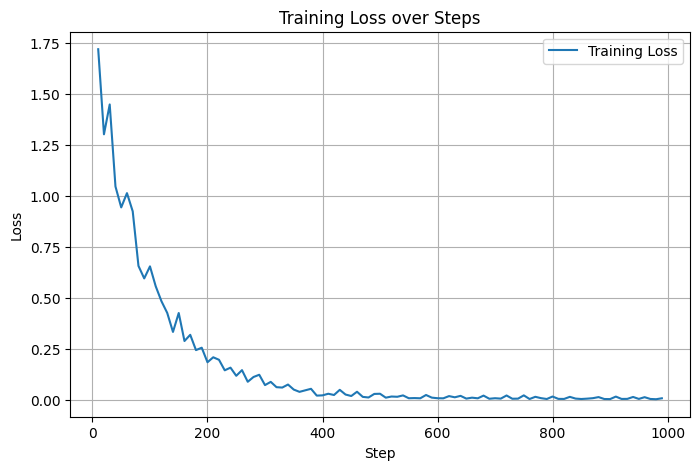

In [3]:
import matplotlib.pyplot as plt

steps = []
train_losses = []

for log in trainer.state.log_history:
    if 'loss' in log:
        steps.append(log['step'])
        train_losses.append(log['loss'])

plt.figure(figsize=(8,5))
plt.plot(steps, train_losses, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# -----------------------------
# 9. Evaluate
# -----------------------------
preds_output = trainer.predict(test_dataset)
preds = preds_output.predictions.argmax(-1)

true_labels = [id2label[int(i)] for i in test_dataset['label']]
pred_labels = [id2label[int(i)] for i in preds]

print(classification_report(true_labels, pred_labels))
# -----------------------------
# 10. Predict unknown labels
# -----------------------------
df_unknown = df[df['label'] == 'unknown'].copy()
df_unknown = df_unknown[df_unknown['body'].str.strip() != ""]
df_unknown['body'] = df_unknown['body'].astype(str)

dataset_unknown = Dataset.from_pandas(df_unknown)
dataset_unknown = dataset_unknown.map(tokenize, batched=True)
dataset_unknown.set_format('torch', columns=['input_ids', 'attention_mask'])

preds_unknown = trainer.predict(dataset_unknown)
pred_labels = [id2label[i] for i in preds_unknown.predictions.argmax(-1)]
df_unknown['predicted_label'] = pred_labels

print(df_unknown[['body', 'predicted_label']])

                 precision    recall  f1-score   support

            bug       0.88      0.95      0.91        60
    dataset bug       0.43      0.43      0.43         7
dataset request       0.96      0.88      0.92        25
 dataset-viewer       1.00      1.00      1.00         4
    enhancement       0.83      0.83      0.83        30
     nlp-viewer       1.00      0.33      0.50         3
       question       0.00      0.00      0.00         2

       accuracy                           0.85       131
      macro avg       0.73      0.63      0.66       131
   weighted avg       0.85      0.85      0.85       131



Map:   0%|          | 0/514 [00:00<?, ? examples/s]

                                                   body  predicted_label
6     ## Intro\r\n\r\nCurrently the two classes have...              bug
11    when I rerun my program, it occurs this error\...      dataset bug
36    Thanks to all of you, `datasets` will pass 11....         question
37    Hi, it seems like there are updates in cluewsc...  dataset request
44    after adding new field **tokenized_examples["e...              bug
...                                                 ...              ...
1211  The following error is raised when the `citati...      enhancement
1212  When a split is empty either TEST, VALIDATION ...      dataset bug
1213  It would be useful to keep the list of the lab...      enhancement
1214  Add the following dataset outputs:\r\n\r\n- Sp...      enhancement
1215  Hello,\r\n\r\nAs proposed by @thomwolf, I open...      enhancement

[514 rows x 2 columns]


In [5]:
df_unknown[['body', 'predicted_label']].to_csv("classified.csv")